In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from scipy.stats import special_ortho_group as sog
from collections import Counter
import freud
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks, optimizers
from tensorflow_graphics.nn.loss import hausdorff_distance
from sklearn.manifold import TSNE
import hdbscan
import seaborn as sns
import PIL
import fresnel


import utils
import models
import testing

# Preprocess

In [3]:
path = 'data/sphere_packing.xyz'

In [4]:
MODEL_NAME = 'AutoEncoderV2'
CLOUD_SIZE = 2
LATENT_DIM = 2
BATCH_SIZE = 32
EPOCHS = 1000

In [5]:
def getNeighbors(box, points):
    linkcell = freud.locality.LinkCell(box, points)
    query_args = dict(mode='nearest', num_neighbors=CLOUD_SIZE, r_min=0.1)
    query = linkcell.query(points, query_args)
    nlist = query.toNeighborList()

    centers = [[0, 0, 0] for i in range(nlist.num_query_points)]
    neighbors = [[] for i in range(nlist.num_query_points)]
    for i, j in nlist[:]:
        point = points[j] - points[i]
        for k in range(3):
            if point[k] > box.Lx / 2:
                point[k] -= box.Lx
            elif point[k] < -box.Lx / 2:
                point[k] += box.Lx
        centers[i] = points[i]
        neighbors[i].append(point)
        
    return np.array(centers), np.array(neighbors)

In [6]:
# def getNeighbors(box, points):
#     voronoi = freud.locality.Voronoi()
#     voronoi.compute(system=(box, points))
#     nlist = voronoi.nlist

#     centers = [[0, 0, 0] for i in range(nlist.num_query_points)]
#     neighbors = [[] for i in range(nlist.num_query_points)]
#     for i, j in nlist[:]:
#         point = points[j] - points[i]
#         for k in range(3):
#             if point[k] > box.Lx / 2:
#                 point[k] -= box.Lx
#             elif point[k] < -box.Lx / 2:
#                 point[k] += box.Lx
#         centers[i] = points[i]
#         neighbors[i].append(point)
        
#     return centers, neighbors

In [7]:
with open(path, 'r') as f:
    N = int(next(f))
    L = float(next(f))
    points = np.loadtxt(f)
    assert len(points) == N

    box = freud.Box.cube(float(L))
    centers, neighbors = getNeighbors(box, points)

In [8]:
voronoi = freud.locality.Voronoi()
voronoi.compute(system=(box, points))
nlist = voronoi.nlist

In [9]:
nlist.weights[:14]

array([1.546946  , 1.6102185 , 1.2854468 , 1.385411  , 0.00872655,
       1.5149317 , 1.5666263 , 1.2858361 , 1.4739083 , 1.3359227 ,
       1.4553051 , 0.00597141, 1.4720925 , 1.4383937 ], dtype=float32)

In [10]:
nlist.distances[:14]

array([2.0006156, 2.000222 , 2.0829597, 2.0501585, 2.8018327, 2.0002596,
       2.0000181, 2.077791 , 2.0000083, 2.0639064, 2.0220351, 2.7997072,
       2.0000324, 2.0000808], dtype=float32)

In [ ]:
nlist.weights[:14] * nlist.distances[:14]

array([3.0948443 , 3.2207944 , 2.6775336 , 2.8403122 , 0.02445033,
       3.0302567 , 3.133281  , 2.6716986 , 2.947829  , 2.7572196 ,
       2.942678  , 0.01671819, 2.9442327 , 2.8769038 ], dtype=float32)

In [ ]:
centers.shape

(1728, 3)

In [12]:
neighbors.shape

(1728, 12, 3)

In [13]:
for neighbor in neighbors:
    for point in neighbor:
        if np.linalg.norm(point) == 0:
            print(np.linalg.norm(point))

In [14]:
centers

array([[19.33462187,  8.0792766 ,  0.83360205],
       [18.97006897, 15.16459377,  1.6412144 ],
       [15.74417816,  4.75271781,  3.43940869],
       ...,
       [ 7.60787464, 17.52510528, 10.75766104],
       [ 4.99657092,  4.25446237, 13.75182394],
       [ 0.07647262, 16.47294871, 19.10963024]])

# Train

In [ ]:
# Build model
model = eval('{}({}, {})'.format(MODEL_NAME, LATENT_DIM, CLOUD_SIZE))
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss=utils.loss_fun(CLOUD_SIZE))

In [ ]:
history = model.fit(x=neighbors,
                    y=neighbors,
                    shuffle=True,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/1000
54/54 [==============================] - 5s 8ms/step - loss: 2.3031
Epoch 2/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.8054
Epoch 3/1000
54/54 [==============================] - 0s 8ms/step - loss: 1.6753
Epoch 4/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.5928
Epoch 5/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.5470
Epoch 6/1000
54/54 [==============================] - 0s 8ms/step - loss: 1.5273
Epoch 7/1000
54/54 [==============================] - 0s 8ms/step - loss: 1.5023
Epoch 8/1000
54/54 [==============================] - 0s 8ms/step - loss: 1.4753
Epoch 9/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.4542
Epoch 10/1000
54/54 [==============================] - 0s 8ms/step - loss: 1.4404
Epoch 11/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.3939
Epoch 12/1000
54/54 [==============================] - 0s 8ms/step - loss: 1.3970
Epoch 13/1000
54/54 [====

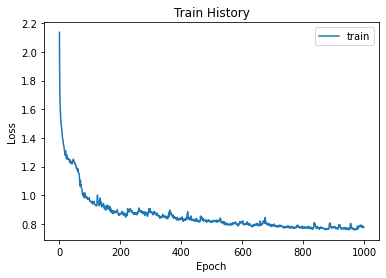

In [ ]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title("Train History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train','validation'])

# Test

In [ ]:
encoded = model.encoder.predict(neighbors)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=N // 10, gen_min_span_tree=True)
clusterer.fit(encoded)
labels = clusterer.labels_
Counter(labels)

Counter({1: 981, -1: 130, 0: 617})

In [ ]:
clusterer.weighted_cluster_centroid(1)

array([-0.55762125,  1.83669173])

In [ ]:
encoded

array([[-1.5524213 ,  2.4368815 ],
       [-0.28213817,  1.5376477 ],
       [ 0.7931036 , -0.12205951],
       ...,
       [-0.49635202,  2.7870126 ],
       [ 4.125928  , -2.491109  ],
       [ 3.9176004 , -3.1055    ]], dtype=float32)

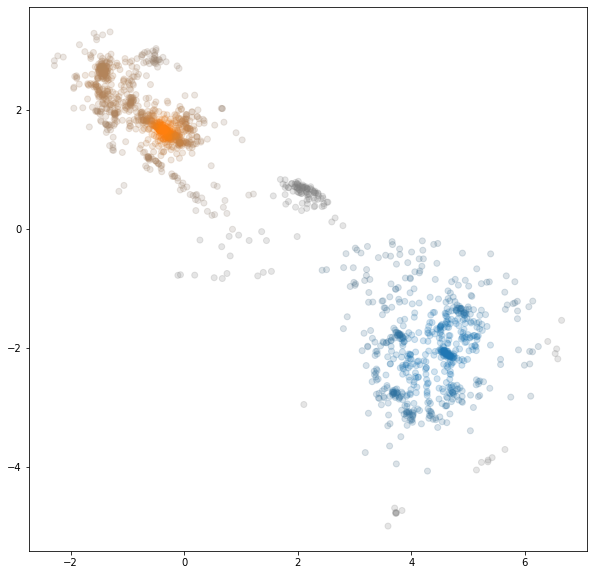

In [ ]:
plt.figure(figsize=(10, 10))
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
scatter = plt.scatter(encoded[:,0], encoded[:,1], c=cluster_colors, alpha=0.2)

<AxesSubplot:>

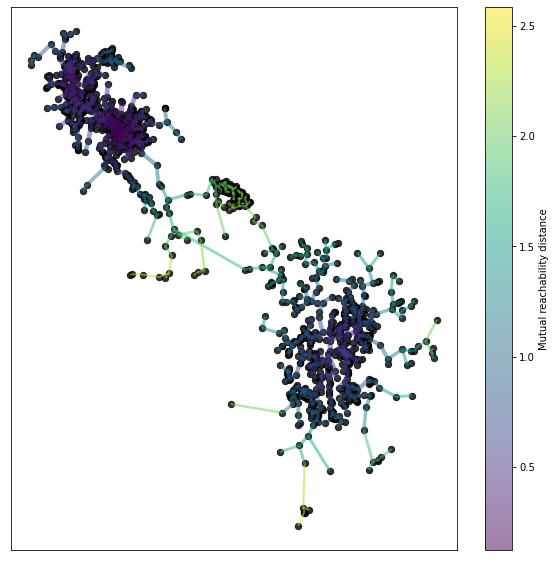

In [ ]:
plt.figure(figsize=(10, 10))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis')

<AxesSubplot:ylabel='distance'>

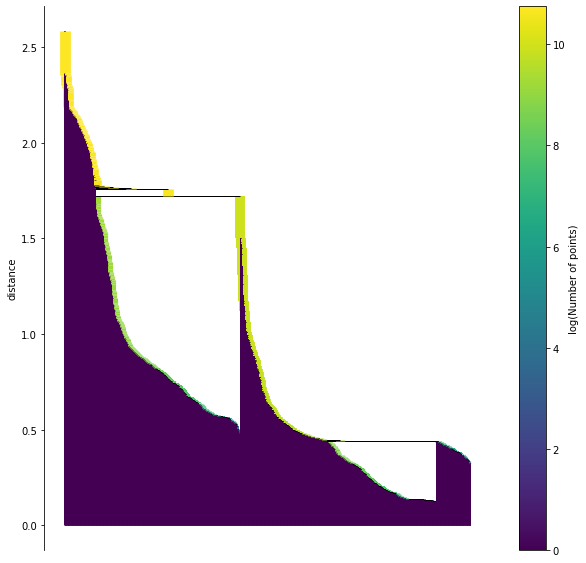

In [ ]:
plt.figure(figsize=(10, 10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

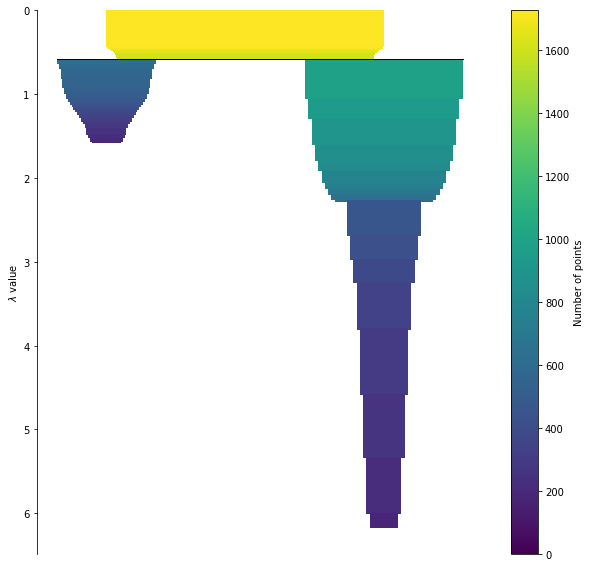

In [ ]:
plt.figure(figsize=(10, 10))
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

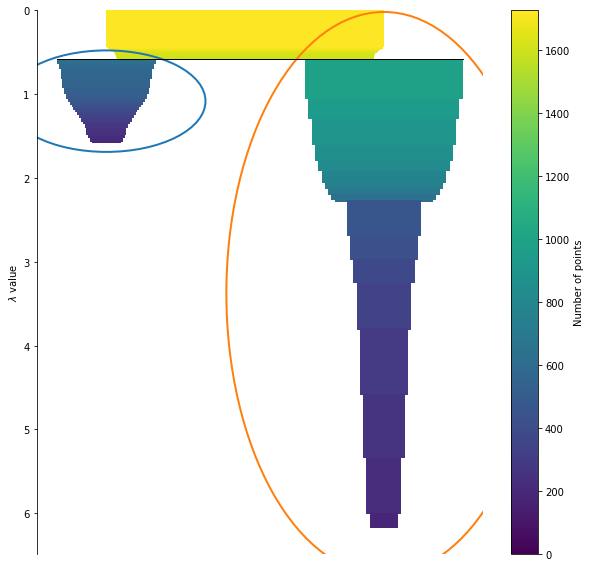

In [ ]:
plt.figure(figsize=(10, 10))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
with open('export.xyz', 'w') as f:
    f.write(str(N) + '\nProperties=species:S:1:pos:R:3\n') 
    stack = np.column_stack((labels+1, centers))
    np.savetxt(f, stack)

In [ ]:
for i in range(len(Counter(labels))-1):
    medoid = clusterer.weighted_cluster_centroid(i)
    idx = np.argmin(np.linalg.norm(encoded - medoid, axis=-1))
    print(encoded[idx])
    X_true = np.expand_dims(neighbors[idx], axis=0)
    X_pred = model.predict(X_true)
    filename = '{}.xyz'.format(i)
    saveXYZ2(filename, X_true[0], X_pred[0])

[ 4.4199495 -2.0612636]
[-0.565866  1.829282]


In [ ]:
encoded[idx]

array([-0.565866,  1.829282], dtype=float32)

In [ ]:
medoid

array([-0.55762125,  1.83669173])

# Experiment

In [ ]:
def _loss_fun(X_true, X_pred):
    # reco_loss = chamfer_distance.evaluate(X_true, X_pred)
    X_true_bt = tf.broadcast_to(tf.expand_dims(X_true, -2), [tf.shape(X_true)[0], CLOUD_SIZE, CLOUD_SIZE, 3]) # (BS, CS, CS, 3)
    X_pred_bt = tf.broadcast_to(tf.expand_dims(X_pred, -3), [tf.shape(X_pred)[0], CLOUD_SIZE, CLOUD_SIZE, 3]) # (BS, CS, CS, 3)
    distance = tf.reduce_sum(tf.square(X_true_bt - X_pred_bt), axis=-1) # (BS, CS, CS)
    mindis = tf.reduce_min(distance, axis=-1) # (BS, CS)

    weight = tf.reduce_sum(tf.square(X_true), axis=-1)
    loss = tf.reduce_mean(tf.divide(mindis, weight), axis=-1)
    return loss

In [ ]:
X_pred = neighbors[:12]

broadcast_2 = tf.broadcast_to(tf.expand_dims(X_pred, -2), [tf.shape(X_pred)[0], CLOUD_SIZE, CLOUD_SIZE, 3]) # (BS, CS, CS, 3)
broadcast_3 = tf.broadcast_to(tf.expand_dims(X_pred, -3), [tf.shape(X_pred)[0], CLOUD_SIZE, CLOUD_SIZE, 3]) # (BS, CS, CS, 3)
distance = tf.reduce_sum(tf.square(broadcast_2 - broadcast_3), axis=-1) # (BS, CS, CS)
truncated = tf.math.maximum(0.0, 4 - distance)
pack_loss = tf.reduce_sum(tf.reduce_sum(truncated, -1), -1) - CLOUD_SIZE * 4

pack_loss

<tf.Tensor: shape=(12,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>

In [ ]:
weight = tf.reduce_sum(tf.square(neighbors[0]), axis=-1)

In [ ]:
np.random.randint(5, size=100)

array([0, 0, 3, 4, 0, 3, 1, 2, 2, 3, 4, 2, 1, 4, 3, 3, 3, 4, 3, 0, 0, 0,
       0, 4, 1, 2, 1, 3, 4, 0, 1, 0, 3, 3, 4, 4, 1, 2, 2, 1, 1, 0, 3, 3,
       0, 4, 2, 1, 2, 1, 2, 2, 4, 0, 4, 3, 1, 2, 2, 2, 0, 1, 0, 2, 4, 1,
       1, 3, 3, 0, 0, 2, 2, 0, 0, 1, 2, 4, 4, 0, 0, 4, 3, 3, 2, 0, 0, 2,
       2, 3, 3, 4, 3, 0, 3, 4, 0, 4, 3, 4])

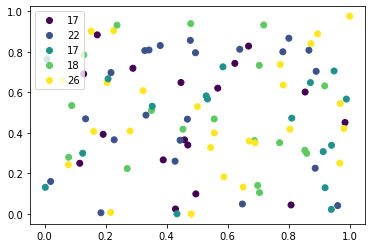

In [ ]:
labels = np.random.randint(5, size=100)
scatter = plt.scatter(np.random.rand(100), np.random.rand(100), c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=np.bincount(labels).tolist())

In [ ]:
np.bincount(labels).astype(str).tolist()

['26', '17', '26', '12', '19']

In [ ]:
palette = sns.color_palette()

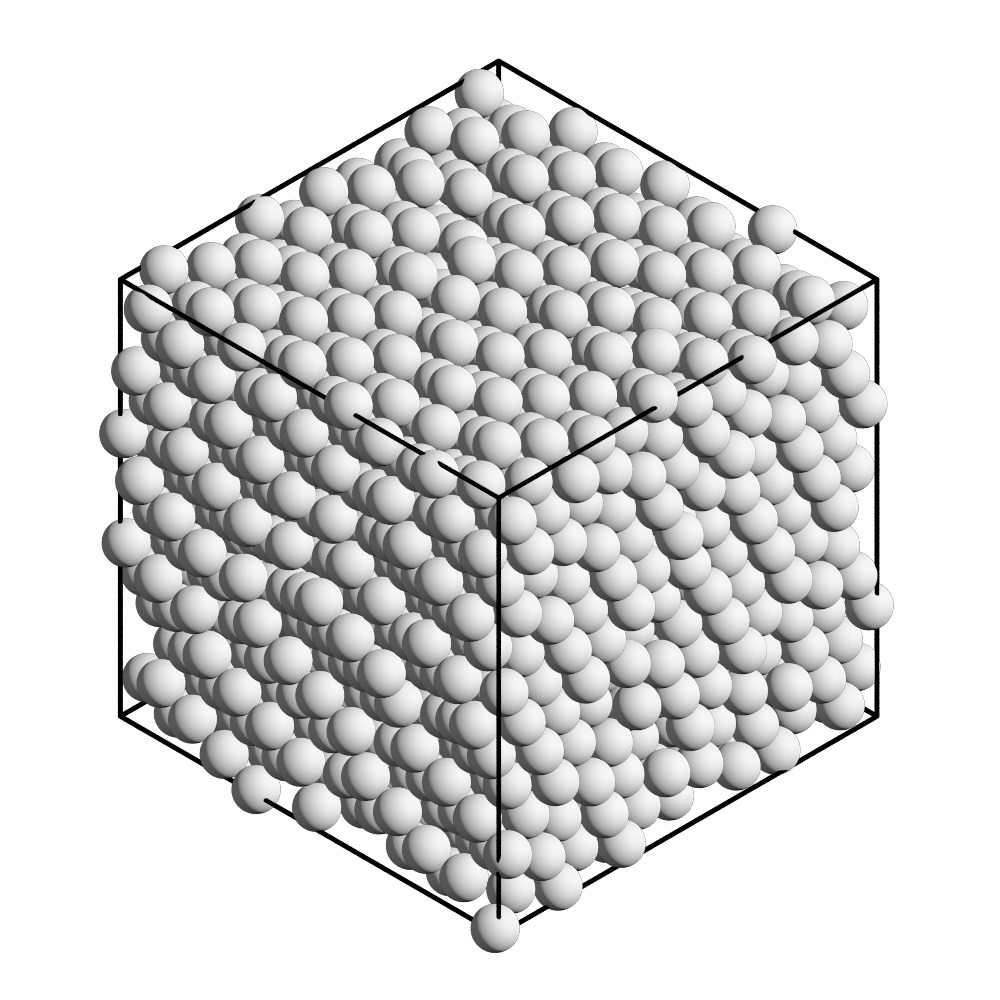

In [26]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(centers))
geometry.material = fresnel.material.Material(roughness=0.8)
geometry.outline_width = 0.01
geometry.position[:] = centers - np.mean(centers, axis=-2)
geometry.radius[:] = [1]
# colors
palette = sns.color_palette()
palette.insert(0, palette.pop(7))
bbox = fresnel.geometry.Box(scene, box, box_radius=.1)
# cluster_colors = [sns.desaturate(palette[col], sat) for col, sat in zip(labels, probabilities)]
# geometry.material.primitive_color_mix = 1
# geometry.color[:] = fresnel.color.linear(cluster_colors)

scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene, w=1000, h=1000)

In [59]:
centers - np.mean(centers, axis=-2)

array([[  8.4542158 ,  -2.94255521, -10.11709894],
       [  8.08966291,   4.14276196,  -9.30948659],
       [  4.8637721 ,  -6.269114  ,  -7.5112923 ],
       ...,
       [ -3.27253143,   6.50327347,  -0.19303995],
       [ -5.88383514,  -6.76736944,   2.80112296],
       [-10.80393344,   5.4511169 ,   8.15892925]])

In [27]:
_=2


In [34]:
np.column_stack(([12], neighbors[0]))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 12

In [58]:
np.insert(neighbors[0], 0, 0, axis=-1)

array([[ 0.        ,  0.77545567, -0.71292745,  1.70084195],
       [ 0.        ,  0.14252481, -1.82948104, -0.79596964],
       [ 0.        ,  0.87822287,  1.67424836, -0.8742665 ],
       [ 0.        , -1.64418329, -0.93059537, -0.79611807],
       [ 0.        , -1.78587342,  0.14907896,  0.88852002],
       [ 0.        , -0.74303298,  0.72847896, -1.70800985],
       [ 0.        , -0.89012583, -1.63891098,  0.91589605],
       [ 0.        ,  1.80868157, -0.85362032, -0.00589806],
       [ 0.        ,  1.63013581,  0.9531402 ,  0.8329988 ],
       [ 0.        ,  1.06253406, -0.13168983, -1.7153155 ],
       [ 0.        , -0.92567722,  1.77288887, -0.01099627],
       [ 0.        , -0.17237467,  1.04841583,  1.69453005]])

In [60]:
neighbors[0]

array([[ 0.77545567, -0.71292745,  1.70084195],
       [ 0.14252481, -1.82948104, -0.79596964],
       [ 0.87822287,  1.67424836, -0.8742665 ],
       [-1.64418329, -0.93059537, -0.79611807],
       [-1.78587342,  0.14907896,  0.88852002],
       [-0.74303298,  0.72847896, -1.70800985],
       [-0.89012583, -1.63891098,  0.91589605],
       [ 1.80868157, -0.85362032, -0.00589806],
       [ 1.63013581,  0.9531402 ,  0.8329988 ],
       [ 1.06253406, -0.13168983, -1.7153155 ],
       [-0.92567722,  1.77288887, -0.01099627],
       [-0.17237467,  1.04841583,  1.69453005]])

In [65]:
np.concatenate([neighbors[0],neighbors[0]],axis=0)

array([[ 0.77545567, -0.71292745,  1.70084195],
       [ 0.14252481, -1.82948104, -0.79596964],
       [ 0.87822287,  1.67424836, -0.8742665 ],
       [-1.64418329, -0.93059537, -0.79611807],
       [-1.78587342,  0.14907896,  0.88852002],
       [-0.74303298,  0.72847896, -1.70800985],
       [-0.89012583, -1.63891098,  0.91589605],
       [ 1.80868157, -0.85362032, -0.00589806],
       [ 1.63013581,  0.9531402 ,  0.8329988 ],
       [ 1.06253406, -0.13168983, -1.7153155 ],
       [-0.92567722,  1.77288887, -0.01099627],
       [-0.17237467,  1.04841583,  1.69453005],
       [ 0.77545567, -0.71292745,  1.70084195],
       [ 0.14252481, -1.82948104, -0.79596964],
       [ 0.87822287,  1.67424836, -0.8742665 ],
       [-1.64418329, -0.93059537, -0.79611807],
       [-1.78587342,  0.14907896,  0.88852002],
       [-0.74303298,  0.72847896, -1.70800985],
       [-0.89012583, -1.63891098,  0.91589605],
       [ 1.80868157, -0.85362032, -0.00589806],
       [ 1.63013581,  0.9531402 ,  0.832

In [92]:
empty = np.zeros([100,100,4])

In [88]:
image = PIL.Image.fromarray(np.random.rand(100,100,4), mode='RGBA')

In [83]:
concat = np.concatenate([image, image], axis=-1)

In [91]:
concat.shape

(100, 100, 8)

In [71]:
ds = tf.data.Dataset.from_tensor_slices((neighbors, neighbors))

In [72]:
def random_rotation(x, y):
    ortho_mats = np.float32(sog.rvs(dim=3))
    return x @ ortho_mats, y @ ortho_mats

In [73]:
list(ds.as_numpy_iterator())[0]

(array([[ 0.77545567, -0.71292745,  1.70084195],
        [ 0.14252481, -1.82948104, -0.79596964],
        [ 0.87822287,  1.67424836, -0.8742665 ],
        [-1.64418329, -0.93059537, -0.79611807],
        [-1.78587342,  0.14907896,  0.88852002],
        [-0.74303298,  0.72847896, -1.70800985],
        [-0.89012583, -1.63891098,  0.91589605],
        [ 1.80868157, -0.85362032, -0.00589806],
        [ 1.63013581,  0.9531402 ,  0.8329988 ],
        [ 1.06253406, -0.13168983, -1.7153155 ],
        [-0.92567722,  1.77288887, -0.01099627],
        [-0.17237467,  1.04841583,  1.69453005]]),
 array([[ 0.77545567, -0.71292745,  1.70084195],
        [ 0.14252481, -1.82948104, -0.79596964],
        [ 0.87822287,  1.67424836, -0.8742665 ],
        [-1.64418329, -0.93059537, -0.79611807],
        [-1.78587342,  0.14907896,  0.88852002],
        [-0.74303298,  0.72847896, -1.70800985],
        [-0.89012583, -1.63891098,  0.91589605],
        [ 1.80868157, -0.85362032, -0.00589806],
        [ 1.630135

In [74]:
ds = ds.map(random_rotation)

In [75]:
list(ds.as_numpy_iterator())[0]

(array([[-0.04430224,  1.40268967,  1.42581881],
        [ 1.53456778,  0.95864298, -0.85263536],
        [-1.75862855, -0.43703557, -1.02710778],
        [ 1.76854103, -0.968412  , -0.37093319],
        [ 0.74445926, -1.30473581,  1.32078811],
        [ 0.01456724, -1.38720525, -1.44066878],
        [ 1.73075508,  0.41717978,  1.07129202],
        [-0.28272226,  1.91781489, -0.49202205],
        [-1.7840656 ,  0.95294259,  0.41075121],
        [-0.26085605,  0.53148049, -1.93341943],
        [-0.95943542, -1.73357935,  0.27261746],
        [-0.98263322, -0.34100225,  1.70835307]]),
 array([[-0.04430224,  1.40268967,  1.42581881],
        [ 1.53456778,  0.95864298, -0.85263536],
        [-1.75862855, -0.43703557, -1.02710778],
        [ 1.76854103, -0.968412  , -0.37093319],
        [ 0.74445926, -1.30473581,  1.32078811],
        [ 0.01456724, -1.38720525, -1.44066878],
        [ 1.73075508,  0.41717978,  1.07129202],
        [-0.28272226,  1.91781489, -0.49202205],
        [-1.784065

In [376]:
import tensorflow as tf
import numpy as np
import random

dx = tf.data.Dataset.from_tensor_slices([10.0, 20.0, 30.0, 40.0])
dx = dx.repeat(2).shuffle(3, reshuffle_each_iteration=False).map(lambda x: x + np.random.uniform(0, 1))
for next_element in dx:
    print(next_element.numpy())

30.251886
20.251886
40.251884
10.251886
10.251886
40.251884
20.251886
30.251886


In [383]:
for next_element in dx:
    print(next_element.numpy())

30.251886
20.251886
40.251884
10.251886
10.251886
40.251884
20.251886
30.251886


In [339]:
tf.random.uniform([], 0, 1).numpy()

0.6687393

In [250]:
tf.Variable(sog.rvs(dim=3))

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float64, numpy=
array([[-0.23976021,  0.93942627,  0.24493534],
       [ 0.51508564, -0.09076406,  0.85231958],
       [ 0.82292273,  0.330515  , -0.46212337]])>

In [183]:
x

array([[-1.75255146,  0.05511877, -0.96208245],
       [ 0.40971276, -1.54844215,  1.1977035 ]])

In [184]:
y

array([[-1.75255146,  0.05511877, -0.96208245],
       [ 0.40971276, -1.54844215,  1.1977035 ]])

In [332]:
tf.random.uniform([], 0, 1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.20670867>

In [117]:
np.float32(neighbors[:2]) @ tf.keras.initializers.Orthogonal()((3,3)).numpy()

array([[[ 0.13616937,  1.6499311 ,  1.1221685 ],
        [-0.98638785,  0.07822352, -1.7380885 ]],

       [[ 0.9354255 , -0.04940854, -1.7671267 ],
        [-0.93061954,  0.05470314,  1.7694895 ]]], dtype=float32)

In [125]:
random_rotation(neighbors[:2])

array([[[ 1.814791  , -0.2609588 , -0.79906887],
        [-0.777767  , -1.4388967 ,  1.1509504 ]],

       [[-1.5046932 , -1.1668454 , -0.6120206 ],
        [ 1.5082852 ,  1.1655694 ,  0.6055258 ]]], dtype=float32)

In [151]:
neighbors = np.float32(neighbors)

In [210]:
dataset = tf.data.Dataset.from_tensor_slices(neighbors[:3])
dataset = dataset.shuffle(len(points))
dataset = dataset.map(lambda x: x @ tf.keras.initializers.Orthogonal()((3,3)))

In [213]:
np.shape(list(dataset.as_numpy_iterator()))

(3, 2, 3)

In [219]:
list(dataset.as_numpy_iterator())[0]

array([[-1.6199231, -1.0517213, -0.519431 ],
       [ 0.2873445,  1.8111566, -0.7982336]], dtype=float32)

In [291]:
for next_element in dataset:
    print(next_element)

(<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[-1.10644735,  1.62304474, -0.37626757],
       [ 1.19901971, -0.71910514, -1.43012971]])>, <tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[-1.10644735,  1.62304474, -0.37626757],
       [ 1.19901971, -0.71910514, -1.43012971]])>)
(<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[ 1.99029848,  0.18129584,  0.07773503],
       [-1.99099924, -0.17397674, -0.07610604]])>, <tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[ 1.99029848,  0.18129584,  0.07773503],
       [-1.99099924, -0.17397674, -0.07610604]])>)
(<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[-1.10644735,  1.62304474, -0.37626757],
       [ 1.19901971, -0.71910514, -1.43012971]])>, <tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[-1.10644735,  1.62304474, -0.37626757],
       [ 1.19901971, -0.71910514, -1.43012971]])>)
(<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[ 1.99029848,  0.18129584,  0.07773503],
       [-1.9909992

In [ ]:
PIL.Image()